<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Four: Neural networks </h2>	


### Introduction

After fiddling around with the previous classifiers, we must move on to the industry standard for image classification. We have chosen to perform transfer learning (see sources). We chose to use ResNet-18 pretrained on the ImageNet dataset, freeze the existing layers and substituting the last fully connected layer with a small sequential layer for classifying our images. We then retrain (only the newly added layer) with our images, calculate training- and validation loss and accuracy and evaluate our model on a separate test set.

This model had very good results, with a accuarcy of $0.9834$ on the test set. We wanted to explore even further with the use of transfer learning and convolutional neural networks, and decided to extract feature embeddings from the last pooling layer of our model and then using a k-NN model to classify our images. This approach had good results, but not as good as the first model. The accuracy reached was $0.8671$. 5-Fold Cross Validation was used to find the optimal k and distance function p for our model.

In [23]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore")

from ipynb.fs.full.GradProject_NB1 import read_training_data
import numpy as np
import pandas as pd
import cv2
from skimage import io
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import matplotlib as matplotlib

from torchvision import models
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from timeit import default_timer as timer
from torch.autograd import Variable
from torch import optim
from torchvision import transforms
import math

import seaborn as sns
sns.set(style = "dark", 
        color_codes = True,
        font_scale = 1.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(42)

In [2]:
%%capture
training_data, label_dict = read_training_data();

In [3]:
y = training_data['Label']
x = training_data['Image']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

**Distribution of images amongst datasets:**

In [4]:
print(f"No of images in training set: {len(x_train)}")
print(f"No of images in validation set: {len(x_val)}")
print(f"No of images in test set: {len(x_test)}")

No of images in training set: 1080
No of images in validation set: 120
No of images in test set: 301


In [5]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        # Importing ResNet-18, pretrained on ImageNet
        self.model = models.resnet18(pretrained=True)
        
        # For retraining the model for our custom classes we freeze the parameters/layers in our model
        # to retrain only the last layer which is soon added below

        # Freeze model weights
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Overwriting last layer
        in_features = self.model.fc.in_features
        no_of_classes = 20
        self.model.fc = nn.Sequential(
                              nn.Linear(in_features, 256), 
                              nn.ReLU(), 
                              nn.Dropout(0.2),
                              nn.Linear(256, no_of_classes),                   
                              nn.LogSoftmax(dim=1))
        
        # Loss and optimizer
        self.criterion = nn.NLLLoss()
        self.optimizer = optim.Adam(self.model.parameters())
    
        self.transform = transforms.Compose([            
                         transforms.Resize(256),         
                         transforms.CenterCrop(224),     
                         transforms.ToTensor(),          
                         transforms.Normalize(           
                         mean=[0.485, 0.456, 0.406],      
                         std=[0.229, 0.224, 0.225]
                         )])
        
    def forward(self, input_tensor):
        """
        Forwarding an input tensor through the neural network
        """
        return self.model(input_tensor)
    
    def fit(self, train_dataloader, val_dataloader, no_of_epochs=10):
        """
        Fitting the last layers, while the others are freezed
        """
        history = []
        for epoch in range(no_of_epochs):
            start = timer()
            train_acc, train_loss = 0.0, 0.0
            val_acc, val_loss = 0.0, 0.0
            
            self.model.train()
            
            for i, (data, targets) in enumerate(train_dataloader):
                # Clear gradients
                self.optimizer.zero_grad()

                # Generate predictions
                output = self.forward(data)

                # Calculate loss
                loss = self.criterion(output, targets.squeeze())

                # Backpropagation
                loss.backward()

                # Update model parameters
                self.optimizer.step()

                # Track training loss 
                train_loss += loss.item() * data.size(0)

                # Calculate accuracy by finding the highest log probability
                _, preds = torch.max(output, dim=1)
                correct_tensor = preds.eq(targets.data.view_as(preds))

                acc = torch.mean(correct_tensor.type(torch.FloatTensor))
                train_acc += acc.item() * data.size(0)

                # Track epoch progress
                print(f'Epoch: {epoch}\t{100 * (i + 1) / len(train_dataloader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.', end='\r')
            
            # Predicting with validation set
            with torch.no_grad():
                self.model.eval()

                for data, targets in val_dataloader:

                    # Forward the image-batch
                    output = self.forward(data)

                    # Validation loss
                    loss = self.criterion(output, targets.squeeze())
                    
                    val_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, preds = torch.max(output, dim=1)
                    correct_tensor = preds.eq(targets.data.view_as(preds))
                    
                    acc = torch.mean(correct_tensor.type(torch.FloatTensor))
                    val_acc += acc.item() * data.size(0)
                    
            # Calculate average losses and accuracies
            train_loss = train_loss / len(train_dataloader.dataset)
            train_acc = train_acc / len(train_dataloader.dataset)
            
            val_loss = val_loss / len(val_dataloader.dataset)
            val_acc = val_acc / len(val_dataloader.dataset)

            history.append([train_loss, val_loss, train_acc, val_acc])

            print(f"\n\tTraining Loss: {train_loss}, Validation Loss: {val_loss}")
            print(f"\tTraining Accuracy: {train_acc}, Validation Accuracy: {val_acc}")
        
        # Creating dataframe with model fitting history
        history = pd.DataFrame(
            history,
            columns=['train_loss',
                     'valid_loss',
                     'train_acc',
                     'valid_acc'])
        
        history.index += 1
        return history
        
    def predict(self, images):
        """
        Predict images with shape (height x width x 3) with model
        Returns predictions and labels
        """
        labels = []
        preds = []
        for image in images:
            with torch.no_grad():
                model.eval()
                img_tensor = self.transform(Image.fromarray(image))
                img_tensor = torch.unsqueeze(img_tensor, 0)

                out = model(img_tensor)
                pred = int(torch.max(out, 1)[1])
                label = label_dict[pred]

                preds.append(pred)
                labels.append(label)

        return preds, labels
    
    
    def get_embedding(self, image):
        """
        Returns the feature matrix from last average pooling layer
        """
        self.model.eval()
        
        # Create image tensor
        img_tensor = self.transform(Image.fromarray(image))
        img_tensor = torch.unsqueeze(img_tensor, 0)
        
        # Torch vector of zeros to store feature vector
        embedding = torch.zeros(self.model.fc[0].in_features)
        
        def copy_features(m, i, o):
            """
            Function to copy the embedding from pooling layer
            """
            embedding.copy_(o.data.squeeze())
            
        # Attach that copy function to last pooling layer
        hook = self.model.avgpool.register_forward_hook(copy_features)
 
        # Evaluate image
        self.model(img_tensor)
        
        # Detach hook for copy function
        hook.remove()
        return embedding.numpy()
    
    def get_activation_map(self, image):
        """
        Returns the activation map from last convolutional layer
        """
        self.model.eval()

        # Create image tensor
        img_tensor = self.transform(Image.fromarray(image))
        img_tensor = torch.unsqueeze(img_tensor, 0)

        # Hook for feature map
        activation = {}
        def get_activation(m, i, o):
            activation['conv1'] = o.detach()

        # Attach that copy function to last pooling layer
        hook = self.model.conv1.register_forward_hook(get_activation)

        # Evaluate image
        self.model(img_tensor)

        # Detach hook for copy function
        hook.remove()
        return activation
    
    def save(self, path="resnet18.pth"):
        """
        Saving model to memory
        """
        torch.save(model, path)
    
    def load(self, path="resnet18.pth"):
        self.model = torch.load(path)
    
    def set_label_mappings(label_mappings):
        """
        Stores label mappings ({0: 'label_name',...})
        """
        # Mapping of Classes to Indexes
        self.idx_to_class = label_mappings
        self.class_to_idx = {label:idx for idx,label in label_mappings.items()}


### Declaration of methods

In [6]:
def create_data_loader(x, y, batch_size=64):
    """
    Creating DataLoader-object from numpy-arrays of images and respective labels
    """
    tensor_x = torch.stack([transform(Image.fromarray(img)) for img in x]) # Transforming to torch tensors
    tensor_y = torch.stack([torch.Tensor(np.array([label])).long() for label in y])

    dataset = TensorDataset(tensor_x, tensor_y) # Create your datset
    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [7]:
def get_precision(predicted_labels, true_labels):
    """
    Return the precision score of the predictions per class in predictions
    """
    truth_per_class = get_truth(predicted_labels, true_labels)
    precision_pr_class = []
    for truth in truth_per_class:
        TP, FP, TN, FN = truth
        precision_pr_class.append(TP / (FP + TP + 10 ** (-8)))
        
    return precision_pr_class


def get_recall(predicted_labels, true_labels):
    """
    The recall score of the predictions per class in the predictions
    """
    truth_per_class = get_truth(predicted_labels, true_labels)
    recall_pr_class = []
    for truth in truth_per_class:
        TP, FP, TN, FN = truth
        recall_pr_class.append(TP / (TP + FN + 10 ** (-8)))
        
    return recall_pr_class

def get_accuracy(predicted_labels, true_labels):
    """
    The accuracies of the predictions per class in the predictions
    """
    truth_per_class = get_truth(predicted_labels, true_labels)
    accuracy_pr_class = []
    for truth in truth_per_class:
        TP, FP, TN, FN = truth
        accuracy_pr_class.append(TP / (TP + FN + 10 ** (-8)))
        
    return accuracy_pr_class


def get_truth(predicted_labels, true_labels, no_of_classes=20):
    """
    The number of True Positives, False Positives, True Negatives and False Negatives respectfully per class
    Returns a list on the format [(TP,FP,TN,FN), ...]
    """
    truth_pr_class = [[0,0,0,0] for _ in range(no_of_classes)] # (TP, FP, TN, FN)
    
    for label, pred in zip(true_labels, predicted_labels):
        if label == pred: # True prediction
            truth_pr_class[label][0] += 1 # True positive for label
            
            for i in range(no_of_classes): # True negative for all other labels
                if i != label:
                    truth_pr_class[i][2] += 1
            
        if label != pred: # False prediction
            truth_pr_class[label][3] += 1 #False negative for label
            truth_pr_class[pred][1] += 1 # False postive for prediction 
    
    return truth_pr_class

def visualize_metrics(predicted_labels, true_labels):
    labels = label_dict.values()
    accuracies = get_accuracy(predicted_labels, true_labels)
    precisions = get_precision(predicted_labels, true_labels)
    recalls = get_recall(predicted_labels, true_labels)
    print(f"{'Class:':<15} {'Accuracy:':<15} {'Precision:':<15} {'Recall:':<5}")
    for i, label in enumerate(labels):
        print(f"{label:<15} {accuracies[i]:.4f} \t\t{precisions[i]:.4f} \t\t{recalls[i]:.4f}")
        
    print(f"\nOverall Accuracy: {accuracy_score(predicted_labels, true_labels):.4f}")

In [165]:
# Creating network
resnet = ConvNet()

In [166]:
train_dataloader = create_data_loader(x_train, y_train)
val_dataloader = create_data_loader(x_val, y_val)

In [167]:
history = resnet.fit(train_dataloader, val_dataloader, no_of_epochs=10)

Epoch: 0	100.00% complete. 120.80 seconds elapsed in epoch.
Training Loss: 2.1927479696273804, Validation Loss: 1.1244806591669718
Training Accuracy: 0.45, Validation Accuracy: 0.825
Epoch: 1	100.00% complete. 118.45 seconds elapsed in epoch.
Training Loss: 0.8815391572316488, Validation Loss: 0.4631243173281352
Training Accuracy: 0.8308333333333333, Validation Accuracy: 0.9349999992052714
Epoch: 2	100.00% complete. 119.79 seconds elapsed in epoch.
Training Loss: 0.44055476586023967, Validation Loss: 0.2695814255873362
Training Accuracy: 0.905, Validation Accuracy: 0.9599999992052713
Epoch: 3	100.00% complete. 121.47 seconds elapsed in epoch.
Training Loss: 0.29855231126149495, Validation Loss: 0.18939813156922658
Training Accuracy: 0.938333334128062, Validation Accuracy: 0.9716666666666667
Epoch: 4	100.00% complete. 117.21 seconds elapsed in epoch.
Training Loss: 0.23879564305146536, Validation Loss: 0.14352879683176675
Training Accuracy: 0.9441666658719381, Validation Accuracy: 0.976

#### Saving the network

In [168]:
resnet.save()

#### Plotting the fitting history

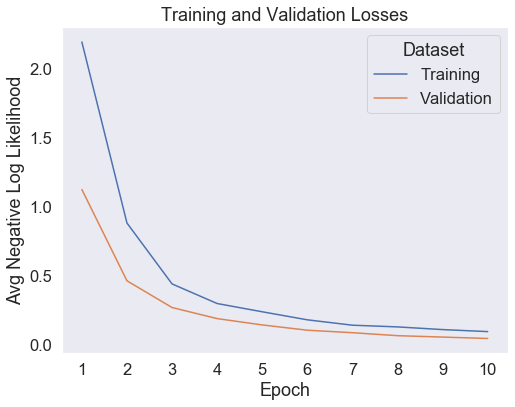

In [495]:
plt.figure(figsize=(8, 6))
    
sns.lineplot(data = history['train_loss'], label='Training')
sns.lineplot(data = history['valid_loss'], label='Validation')

plt.legend(title="Dataset")
plt.xlabel('Epoch')
plt.xticks([i + 1 for i in range(len(history))])
plt.ylabel('Avg Negative Log Likelihood')
plt.title('Training and Validation Losses');

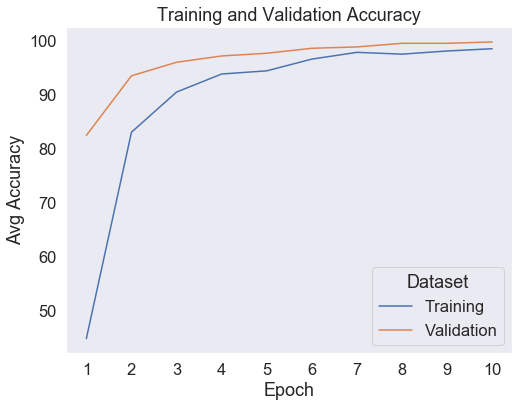

In [496]:
plt.figure(figsize=(8, 6))

ax = sns.lineplot(data = history['train_acc'] * 100, label='Training')
ax = sns.lineplot(data = history['valid_acc'] * 100, label='Validation')

plt.legend(title="Dataset")
plt.xlabel('Epoch')
plt.ylabel('Avg Accuracy')
plt.xticks([i + 1 for i in range(len(history))])
plt.title('Training and Validation Accuracy');

### Evaluating model on test set

In [522]:
resnet = ConvNet()
resnet.load()

In [434]:
preds, labels = resnet.predict(x_test.values)

In [463]:
print("Test metrics")
visualize_metrics(preds, y_test.values)

Test metrics
Class:          Accuracy:       Precision:      Recall:
airplanes       1.0000 		1.0000 		1.0000
bear            1.0000 		1.0000 		1.0000
blimp           1.0000 		1.0000 		1.0000
comet           0.9333 		1.0000 		0.9333
crab            1.0000 		1.0000 		1.0000
dog             1.0000 		1.0000 		1.0000
dolphin         0.9375 		0.9375 		0.9375
giraffe         0.9167 		1.0000 		0.9167
goat            0.9500 		0.9500 		0.9500
gorilla         1.0000 		1.0000 		1.0000
kangaroo        1.0000 		1.0000 		1.0000
killer-whale    1.0000 		0.8333 		1.0000
leopards        1.0000 		0.9600 		1.0000
llama           1.0000 		1.0000 		1.0000
penguin         1.0000 		1.0000 		1.0000
porcupine       0.9500 		1.0000 		0.9500
teddy-bear      1.0000 		1.0000 		1.0000
triceratops     1.0000 		1.0000 		1.0000
unicorn         1.0000 		1.0000 		1.0000
zebra           1.0000 		1.0000 		1.0000

Overall Accuracy: 0.9834


##### Predicting random test image with model

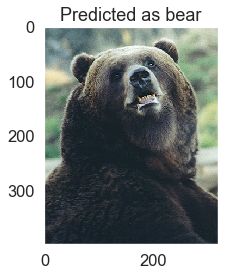

In [504]:
random_image = random.choice([i for i in range(len(x_test))])
img = x_test.values[random_image]

pred, label = resnet.predict([img])

plt.imshow(img)
plt.title(f"Predicted as {label[0]}");

### Visualizing activations in convolutional layer
Below is a grid of feature activations in the first convolutional layer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

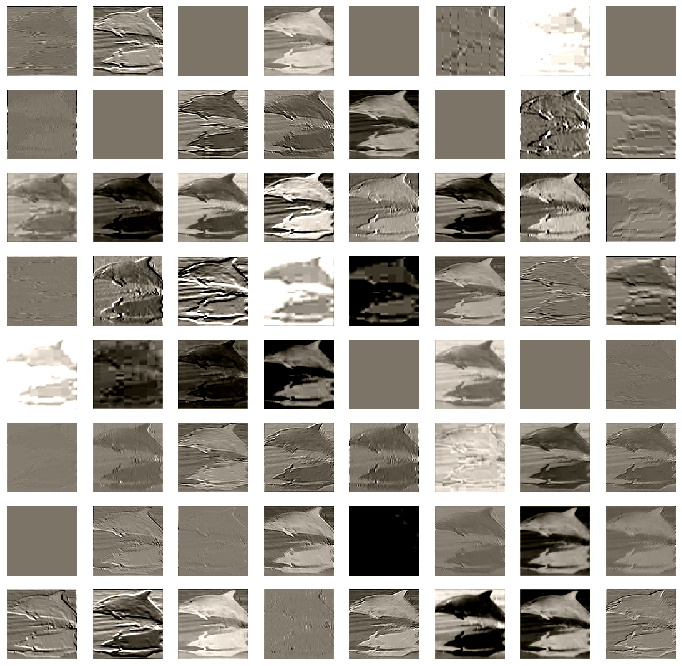

In [47]:
def show_activation(img, ax):
    """
    Function to show activations from convolutional layer
    """
    # Standard deviation and mean corrections from transforming images
    normalizer = resnet.transform.transforms[3]
    std, mean = np.asarray(normalizer.std).reshape(3, 1, 1),  np.asarray(normalizer.mean).reshape(3, 1, 1)
    numpy_img = np.multiply(img.numpy(), std) +  mean

    #plot the numpy image
    ax.axis("off");
    ax.imshow(np.transpose(numpy_img, (1, 2, 0)));

    
def visualize_feature_map(img):
    """
    Visualizes the activations given an image in the first convolutional layer of our network
    Don't mind the excessive outputs
    """
    img = x_test.values[1]
    img_tensor = resnet.transform(Image.fromarray(img))
    img_tensor = torch.unsqueeze(img_tensor, 0)

    conv_features = resnet.get_activation_map(img)
    activations = conv_features['conv1'].squeeze()

    # Calculating size of image grid
    width = int(math.sqrt(activations.size(0)))
    height = activations.size(0)//width
    
    fig, axarr = plt.subplots(width, height, figsize=(12,12))
    idx = 0
    for i in range(width):
        for j in range(height):
            show_activation(activations[idx], axarr[i][j])
            idx += 1

    plt.show();
    
img = x_test.values[1]
visualize_feature_map(img);

## Using CNN to extract image embeddings for k-NN

In [8]:
# Creating model
resnet = ConvNet()
resnet.load()

In [488]:
# Embedding all images

def get_image_embeddings(images):
    """
    Extracting embeddings for all images in input array
    """
    embeddings = []
    for i, img in enumerate(images):
        print(f"[{round((i+1)/len(images) * 100,1)}%] Embedded {i} images", end='\r')
        embeddings.append(resnet.get_embedding(img))
    return np.array(embeddings)

print("\nEmbedding training and validation images:")
embedded_x_train_val = get_image_embeddings(np.concatenate((x_train.values, x_val.values)))
y_train_val = np.concatenate((y_train.values, y_val.values))

print("\nEmbedding training images:")
embedded_x_test = get_image_embeddings(x_test.values)


Embedding training and validation images:
[100.0%] Embedded 1199 images
Embedding training images:


### Cross-validating k-NN model to find optimal k

In [489]:
# Cross-validation
def compute_CV_rmse_and_acc(model, X_train, Y_train, n_splits=5):
    """
    Performing 5-Fold Cross-Validation on model.
    Returning the average validation error and accuracy for the 5 splits.
    """
    kf = KFold(n_splits=n_splits)
    validation_errors = []
    validation_accuracies = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # Split the data
        split_X_train, split_X_valid = np.take(X_train, train_idx, axis=0), np.take(X_train, valid_idx, axis=0)
        split_Y_train, split_Y_valid = np.take(Y_train, train_idx, axis=0), np.take(Y_train, valid_idx, axis=0)
        
        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE on the validation split
        preds = model.predict(split_X_valid)
        error = np.sqrt(np.sum((split_Y_valid - preds)**2)/len(preds))
        acc = accuracy_score(split_Y_valid, preds)
        
        validation_errors.append(error)
        validation_accuracies.append(acc)
        
    return np.mean(validation_errors), np.mean(validation_accuracies)

# Finding best distance function (1: manhattan, 2: euclidian) and k (number of nearest neighbors)
print("Cross validating k-NN model to find optimal p and k")
for p in [1, 2]:
    print(f"P = {p}:")
    for k in range(1, 10 + 1):
        knn = KNeighborsClassifier(n_neighbors=k, p=p)
        val_error, val_acc = compute_CV_rmse_and_acc(knn, embedded_x_train_val, y_train_val)
        print(f"\tK = {k}, Accuracy: {val_acc:.4f}, RSME: {val_error:.4f}")
    

Cross validating k-NN model to find optimal p and k
P = 1:
	K = 1, Accuracy: 0.8500, RSME: 2.7576
	K = 2, Accuracy: 0.8250, RSME: 2.9551
	K = 3, Accuracy: 0.8642, RSME: 2.7429
	K = 4, Accuracy: 0.8758, RSME: 2.6840
	K = 5, Accuracy: 0.8742, RSME: 2.4741
	K = 6, Accuracy: 0.8725, RSME: 2.5366
	K = 7, Accuracy: 0.8792, RSME: 2.3937
	K = 8, Accuracy: 0.8775, RSME: 2.5157
	K = 9, Accuracy: 0.8758, RSME: 2.4975
	K = 10, Accuracy: 0.8717, RSME: 2.5278
P = 2:
	K = 1, Accuracy: 0.8533, RSME: 2.8946
	K = 2, Accuracy: 0.8433, RSME: 2.8256
	K = 3, Accuracy: 0.8750, RSME: 2.5594
	K = 4, Accuracy: 0.8717, RSME: 2.5629
	K = 5, Accuracy: 0.8800, RSME: 2.4539
	K = 6, Accuracy: 0.8850, RSME: 2.4242
	K = 7, Accuracy: 0.8833, RSME: 2.3426
	K = 8, Accuracy: 0.8858, RSME: 2.3062
	K = 9, Accuracy: 0.8875, RSME: 2.2434
	K = 10, Accuracy: 0.8875, RSME: 2.2495


### Predicting k-NN model with optimal k on test set

We see from the cross-validation above, that the optimal k is 1 and p is 2. 

Therefore, we continue with k = 1 and p = 2, that means that it chooses the nearest neighbor with L2 (euclidian) distance.

In [490]:
# Creating and fitting model
knn = KNeighborsClassifier(n_neighbors=1, p=2)
knn.fit(embedded_x_train_val, y_train_val)
        
test_predictions = knn.predict(embedded_x_test)
visualize_metrics(test_predictions, y_test.values)

Class:          Accuracy:       Precision:      Recall:
airplanes       1.0000 		0.9524 		1.0000
bear            0.7143 		0.8333 		0.7143
blimp           0.9167 		1.0000 		0.9167
comet           0.8750 		0.8750 		0.8750
crab            0.9167 		0.9167 		0.9167
dog             0.5455 		0.6667 		0.5455
dolphin         0.7500 		0.6923 		0.7500
giraffe         1.0000 		0.8750 		1.0000
goat            0.6875 		0.6875 		0.6875
gorilla         1.0000 		0.9474 		1.0000
kangaroo        0.9091 		0.9091 		0.9091
killer-whale    1.0000 		0.8889 		1.0000
leopards        1.0000 		1.0000 		1.0000
llama           0.6667 		0.6667 		0.6667
penguin         0.8462 		0.9167 		0.8462
porcupine       0.8571 		1.0000 		0.8571
teddy-bear      0.9444 		0.8947 		0.9444
triceratops     0.9231 		1.0000 		0.9231
unicorn         0.7500 		0.7500 		0.7500
zebra           1.0000 		1.0000 		1.0000

Overall Accuracy: 0.8837


### Sources

* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb
* https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce
* From Intra-Modal to Inter-Modal Space: Multi-Task Learning of Shared Representations for Cross-Modal Retrieval (J. Choi, G. Friedland et.al): 
  * https://www.osti.gov/servlets/purl/1562385
* https://en.wikipedia.org/wiki/Transfer_learning
* https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e


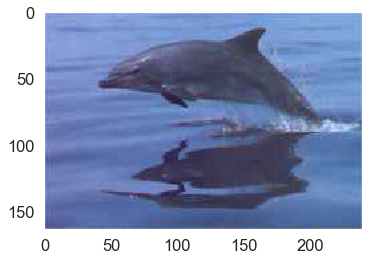

In [17]:
plt.imshow(img)